In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
def convert_data2string(df):
    vals = df.values.astype(str)
    vals = np.array([' '.join(x) for x in vals])

    # should be fine now, but this checks that nothing is getting truncated due to type casting
    test = np.array([[y.isdigit() for y in x.split(' ')] for x in vals])
    assert (test.sum(axis=-1) == df.shape[-1]).all()

    return vals

In [3]:
# Tracts random
files_orig_rand = glob.glob('../results/init_random/tracts_without_block/*original*.t7')
files_rec_rand = glob.glob('../results/init_random/tracts_without_block/*reconstructed*.t7')
files_orig_rand = sorted(files_orig_rand)
files_rec_rand = sorted(files_rec_rand)
print(len(files_orig_rand), len(files_rec_rand))

50 50


In [6]:
# Etract Alabama tract (random)
alabama_orig_tract = torch.load(files_orig_rand[0])
rec_tract_rand = torch.load(files_rec_rand[0])
alabama_rec_tract_rand = None
for d in rec_tract_rand:
    if alabama_rec_tract_rand is None:
        alabama_rec_tract_rand = d
    else:
        alabama_rec_tract_rand = pd.concat([alabama_rec_tract_rand, d])

alabama_orig_tract.to_csv('alabama_original_tract(no_block_attr)_ppmf_01097007000.csv', index=False)
alabama_rec_tract_rand.to_csv('alabama_random_reconstructed_tract(no_block_attr)_ppmf_01097007000.csv', index=False)

In [4]:
# The total number of records, and the total number of record prototypes in the dataset
records_in_orig = 0
prototypes_in_orig = 0
for i in range(len(files_orig_rand)):
    orig_data = torch.load(files_orig_rand[i])
    uniq_orig_data = orig_data.drop_duplicates().reset_index(drop=True)
    records_in_orig+= len(orig_data)
    prototypes_in_orig += len(uniq_orig_data)
print('Tract without block')
print('Records in D:', records_in_orig)
print('Prototypes in D:', prototypes_in_orig)

Tracts (without block)
Records in D: 103093
Prototypes in D: 12092


In [5]:
# The total number of records, and the total number of record prototypes in the reconstructions (random)
records_in_rec = 0
prototypes_in_rec = 0
for i in range(len(files_rec_rand)):
    rec_data = torch.load(files_rec_rand[i])
    all_rec_data = None
    for d in rec_data:
        if all_rec_data is None:
            all_rec_data = d
        else:
            all_rec_data = pd.concat([all_rec_data, d])
    
    uniq_rec_data = all_rec_data.drop_duplicates().reset_index(drop=True)
    records_in_rec+= len(all_rec_data)
    prototypes_in_rec+= len(uniq_rec_data)

print('Tract without block (random)')
print('Records in D\':', records_in_rec)
print('Prototypes in D\':', prototypes_in_rec)

Tracts (without block, random)
Records in D': 10309300
Prototypes in D': 96886


In [4]:
# The total number of records, and the total number of record prototypes in the reconstructions that are not in the dataset (random)
in_orig_rand = []
in_rec_rand = []

for i in range(len(files_orig_rand)):
    orig_data = torch.load(files_orig_rand[i])
    rec_data = torch.load(files_rec_rand[i])
    all_rec_data = None
    for d in rec_data:
        if all_rec_data is None:
            all_rec_data = d
        else:
            all_rec_data = pd.concat([all_rec_data, d])

    orig_data_str = convert_data2string(orig_data)
    all_rec_data_str = convert_data2string(all_rec_data)
    uniq_rec_data = all_rec_data.drop_duplicates().reset_index(drop=True)
    uniq_rec_data_str = convert_data2string(uniq_rec_data)
    
    
    for prototype in uniq_rec_data_str:
        n_in_orig = len(np.where(orig_data_str == prototype)[0])
        n_in_rec = len(np.where(all_rec_data_str == prototype)[0])
        in_orig_rand.append(n_in_orig)
        in_rec_rand.append(n_in_rec)
            
in_orig_rand = np.array(in_orig_rand)
in_rec_rand = np.array(in_rec_rand)
idxs = (in_orig_rand == 0)
print('Tract without block (random):')
print('Records in D\':', in_rec_rand[idxs].sum()) 
print('Prototypes in D\':', len(in_rec_rand[idxs]))

Tract (random):
Records in D': 1658178
Prototypes in D': 85033


In [4]:
# The total number of records, and the total number of record prototypes in the dataset that are not in the reconstructions(random)

in_orig_rand = []
in_rec_rand = []

for i in range(len(files_orig_rand)):
    orig_data = torch.load(files_orig_rand[i])
    rec_data = torch.load(files_rec_rand[i])
    all_rec_data = None
    for d in rec_data:
        if all_rec_data is None:
            all_rec_data = d
        else:
            all_rec_data = pd.concat([all_rec_data, d])

    orig_data_str = convert_data2string(orig_data)
    all_rec_data_str = convert_data2string(all_rec_data)
    uniq_orig_data_str = convert_data2string(orig_data.drop_duplicates().reset_index(drop=True))
    
    for prototype in uniq_orig_data_str:
        n_in_orig = len(np.where(orig_data_str == prototype)[0])
        n_in_rec = len(np.where(all_rec_data_str == prototype)[0])
        in_orig_rand.append(n_in_orig)
        in_rec_rand.append(n_in_rec)
            
in_orig_rand = np.array(in_orig_rand)
in_rec_rand = np.array(in_rec_rand)
idxs = (in_rec_rand == 0)
print('Tract without block (random):')
print('Records in D:', in_orig_rand[idxs].sum()) 
print('Prototypes in D:', len(in_orig_rand[idxs]))

Tract (random):
Records in D: 364
Prototypes in D: 239


In [6]:
# Percentage of appearances in reconstructions of rare record prototypes that occur once, twice, or three times in D
idxs1 = (in_orig_rand == 1) * (in_rec_rand == 1)
idxs2 = (in_rec_rand == 1)
r1 = in_rec_rand[idxs1].sum()/in_rec_rand[idxs2].sum()

print('Tract without block (random) 1 in D:{:0.2f}%'.format(r1*100))

idxs1 = (in_orig_rand == 2) * (in_rec_rand <= 2)
idxs2 = (in_rec_rand <= 2)
r2 = in_rec_rand[idxs1].sum()/in_rec_rand[idxs2].sum()

print('Tract without block (random) 2 in D:{:0.2f}%'.format(r2*100))


idxs1 = (in_orig_rand == 3) * (in_rec_rand <= 3)
idxs2 = (in_rec_rand <= 3)
r3 = in_rec_rand[idxs1].sum()/in_rec_rand[idxs2].sum()

print('Tract without block (random) 3 in D:{:0.2f}%'.format(r3*100))

Tract without block (random) 1 in D:0.15%
Tract without block (random) 2 in D:0.16%
Tract without block (random) 3 in D:0.15%


In [6]:
# For visualizating correlation
in_orig_rand = []
in_rec_rand = []

for i in range(len(files_orig_rand)):
    orig_data = torch.load(files_orig_rand[i])
    rec_data = torch.load(files_rec_rand[i])
    all_rec_data = None
    for d in rec_data:
        if all_rec_data is None:
            all_rec_data = d
        else:
            all_rec_data = pd.concat([all_rec_data, d])

    orig_data_prototypes = orig_data.drop_duplicates().reset_index(drop=True)
    orig_data_str = convert_data2string(orig_data)
    all_rec_data_str = convert_data2string(all_rec_data)
    orig_data_prototypes = convert_data2string(orig_data_prototypes)
    
    for prototype in orig_data_prototypes:
        n_in_orig = len(np.where(orig_data_str == prototype)[0])
        n_in_rec = len(np.where(all_rec_data_str == prototype)[0])
        in_orig_rand.append(n_in_orig)
        in_rec_rand.append(n_in_rec)
            

in_orig_rand = np.array(in_orig_rand)
in_rec_rand = np.array(in_rec_rand)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi= 300, facecolor='w', edgecolor='k')

ax = sns.scatterplot(x = in_orig_rand, y = in_rec_rand,
                edgecolor = "black", hue = in_rec_rand)
ax.set(xlabel='Occurences in D', ylabel='Frequency in reconstructions')
pr = pearsonr(in_orig_rand, in_rec_rand)
# legend.get_frame().set_edgecolor('1.0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# # set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
ax.get_legend().remove()

plt.xlabel('Occurences in D')
plt.ylabel('Frequency in reconstructions')
plt.figtext(0.3, 0.65, f'Pearson\'s r  = {pr.statistic:0.4f}')
plt.tight_layout()
plt.savefig('figures/corr_tract_without_block_random.png', dpi = 300)
plt.show()


In [4]:
# Attribute disclosure experiments
orig_prototype_confidential_attr_same = []
orig_prototype_confidential_attr_diff = []
rec_prototype_confidential_attr_match = []
rec_prototype_confidential_attr_no_match = []
cnfd_attr_in_origi = []

for i in range(len(files_orig_rand)):
    orig_data = torch.load(files_orig_rand[i])
    rec_data =  pd.concat([d for d in torch.load(files_rec_rand[i])])

    # Remove 'CENRACE' column from original and reconstructed data
    orig_data_public_attr = orig_data.drop('CENRACE', axis=1)
    rec_data_public_attr = rec_data.drop('CENRACE', axis=1)

    # Convert DataFrames to strings
    orig_data_public_attr_str = convert_data2string(orig_data_public_attr)
    rec_data_public_attr_str = convert_data2string(rec_data_public_attr)

    # Create prototype sets and initialize dictionary
    prototype_orig_data_public_attr = sorted(set(orig_data_public_attr_str))

    # Collect confidential attribute data
    for prototype in prototype_orig_data_public_attr:
        idxs1 = np.where(orig_data_public_attr_str == prototype)[0]
        idxs2 = np.where(rec_data_public_attr_str == prototype)[0]
        cnfd1 = orig_data.iloc[idxs1]['CENRACE'].values
        cnfd2 = rec_data.iloc[idxs2]['CENRACE'].values
        if np.all(cnfd1 == cnfd1[0]):
            orig_prototype_confidential_attr_same.append(len(cnfd1))
            if np.all(cnfd2 == cnfd1[0]):
                rec_prototype_confidential_attr_match.append(cnfd2)
            else:
                cnfd_attr_in_origi.append(cnfd1[0])
                rec_prototype_confidential_attr_no_match.append(cnfd2)
        else:
            orig_prototype_confidential_attr_diff.append(len(cnfd1))

orig_prototype_confidential_attr_same = np.array(orig_prototype_confidential_attr_same)
orig_prototype_confidential_attr_diff = np.array(orig_prototype_confidential_attr_diff)
cnfd_attr_in_origi = np.array(cnfd_attr_in_origi)

In [5]:
# Number of prototypes in D with and without identical confidential attribute 
print('# Prototypes in D:', len(orig_prototype_confidential_attr_same) + len(orig_prototype_confidential_attr_diff))
print('# Prototypes with the same Race in D:', len(orig_prototype_confidential_attr_same))

# Prototypes in D: 8798
# Prototypes with the same Race in D: 6197


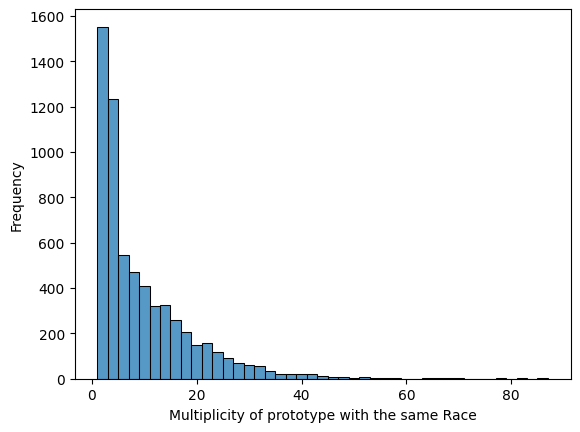

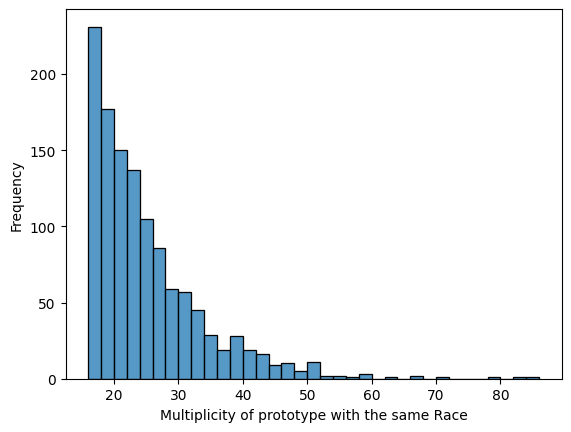

In [6]:
# # Plot a histogram with their distribution by their multiplicity. 
idxs = (orig_prototype_confidential_attr_same > 0)
ax = sns.histplot(orig_prototype_confidential_attr_same[idxs], kde = False, binwidth=2)
ax.set(xlabel='Multiplicity of prototype with the same Race', ylabel='Frequency')
plt.savefig('figures/tract(no block)_rand_orig_prototype_same_multiplicity_hist_filter_0.png', dpi = 300)
plt.show()

# Plot the histogram also without singletons (prototypes with multiplicity=1). 
idxs = (orig_prototype_confidential_attr_same > 15)
ax = sns.histplot(orig_prototype_confidential_attr_same[idxs], kde = False, binwidth=2)
ax.set(xlabel='Multiplicity of prototype with the same Race', ylabel='Frequency')
plt.savefig('figures/tract(no block)_rand_orig_prototype_same_multiplicity_hist_filtered_15.png', dpi = 300)
plt.show()
# # Also, which is the maximum multiplicity of these prototypes?
# print('Maximum multiplicity of these prototypes:', orig_prototype_confidential_attr_same.max())

In [7]:
# How many of them appear in D' by matching confidential attributes
print('Appear in D\' with matching confidential attributes:', len(rec_prototype_confidential_attr_match))
print('Appear in D\' with non-matching confidential attributes:', len(rec_prototype_confidential_attr_no_match))

Appear in D' with matching confidential attributes: 172
Appear in D' with non-matching confidential attributes: 6025


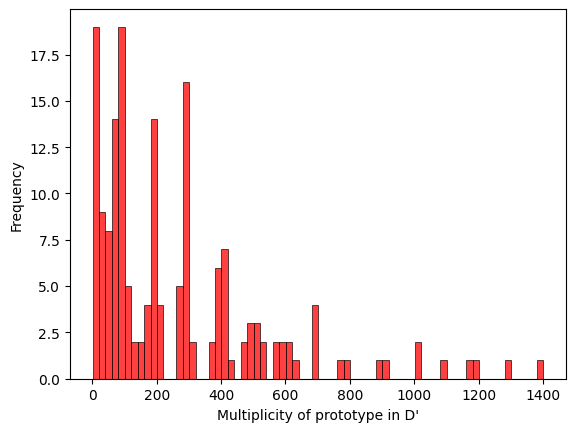

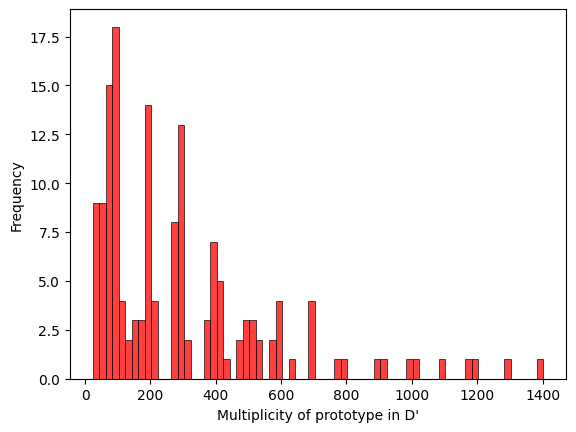

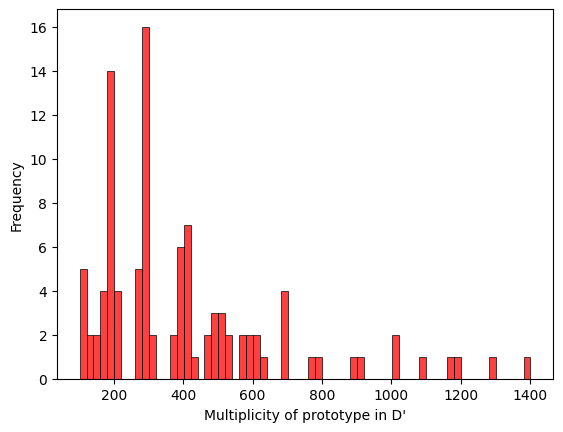

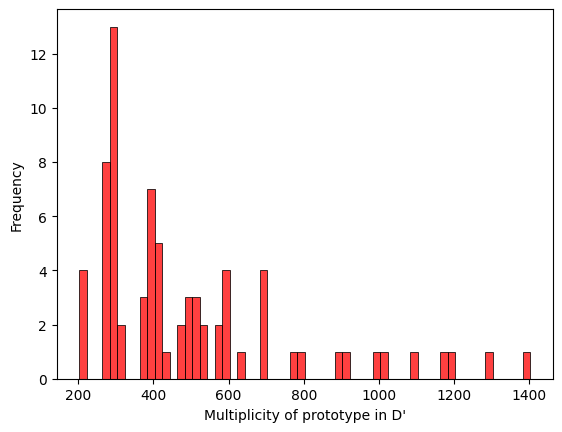

In [8]:
# Histogram of matching prototypes in D'
data = np.array([len(d) for d in rec_prototype_confidential_attr_match])
for filtr in [0, 20, 100, 200]:
    idxs = (data > filtr)
    ax = sns.histplot(data=data[idxs], label='Matching', kde = False, binwidth=20, color = 'red')
    ax.set(xlabel='Multiplicity of prototype in D\'', ylabel='Frequency')
    plt.savefig('figures/tract(no block)_rand_rec_prototype_matching_multiplicity_hist_filter_{}.png'.format(filtr), dpi = 300)
    plt.show()

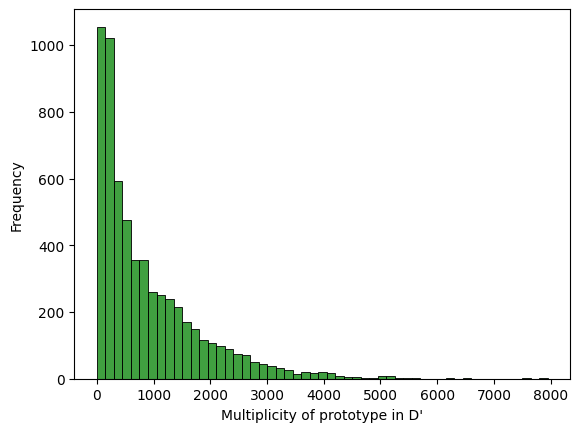

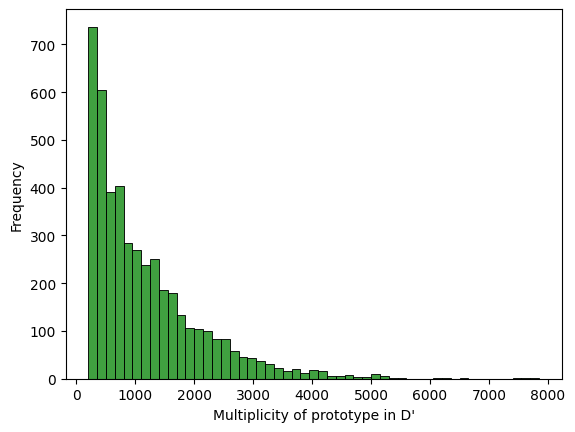

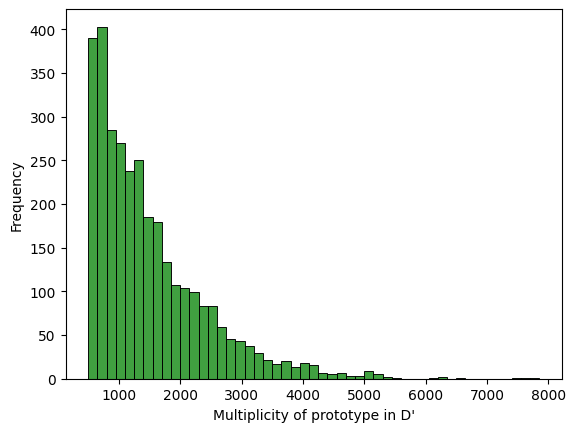

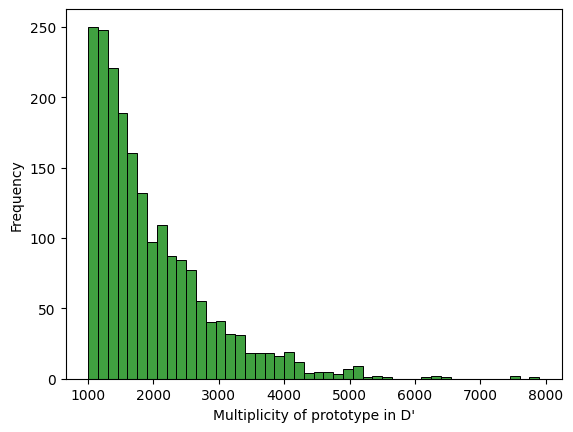

In [9]:
# Histogram of non-matching prototypes in D'
data = np.array([len(d) for d in rec_prototype_confidential_attr_no_match])
for filtr in [0, 200, 500, 1000]:
    idxs = (data > filtr)
    ax = sns.histplot(data=data[idxs], label='Non-matching', kde = False, binwidth=150, color = 'green')
    ax.set(xlabel='Multiplicity of prototype in D\'', ylabel='Frequency')
    plt.savefig('figures/tract(no block)_rand_rec_prototype_non_matching_multiplicity_hist_filter_{}.png'.format(filtr), dpi = 300)
    plt.show()

In [10]:
# Divergence in confidential attribute of non-matching records
avg_diff = []
for cnfd, cnfds in zip(cnfd_attr_in_origi, rec_prototype_confidential_attr_no_match):
    a = (cnfds!=cnfd).mean()
    avg_diff.append(a)

print('Avergae divergence in confidential attribute for non-matching records:{:0.2f}%'.format(np.mean(avg_diff)*100))

Avergae divergence in confidential attribute for non-matching records:25.64%
